In [25]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
# reading the data into variable called name
import csv

names = []
with open('arabic_names.csv', 'r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        names.append(row[0])

names.pop(0)
print(f"The length of names is {len(names)}")
print(f"The first 5 names are {names[:5]}")

The length of names is 1405
The first 5 names are ['ابتسام', 'ابتهاج', 'ابتهال', 'اجتهاد', 'ازدهار']


In [27]:
# Randomizing the data set
random.seed(56)
random.shuffle(names)

n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))
print(f"the data set have {len(names)}, {n1=}, {n2=}")

the data set have 1405, n1=1124, n2=1264


In [28]:
# converting characters to number
chars = sorted(list(set(''.join(names))))
chars.insert(0, '.')

# create character to integer
ctoi = {value: index for index, value in enumerate(chars)}

# create integer to character
itoc = {value: index for index, value in ctoi.items()}

In [29]:
ctoi

{'.': 0,
 ' ': 1,
 'ء': 2,
 'آ': 3,
 'أ': 4,
 'ؤ': 5,
 'إ': 6,
 'ئ': 7,
 'ا': 8,
 'ب': 9,
 'ة': 10,
 'ت': 11,
 'ث': 12,
 'ج': 13,
 'ح': 14,
 'خ': 15,
 'د': 16,
 'ذ': 17,
 'ر': 18,
 'ز': 19,
 'س': 20,
 'ش': 21,
 'ص': 22,
 'ض': 23,
 'ط': 24,
 'ظ': 25,
 'ع': 26,
 'غ': 27,
 'ف': 28,
 'ق': 29,
 'ك': 30,
 'ل': 31,
 'م': 32,
 'ن': 33,
 'ه': 34,
 'و': 35,
 'ى': 36,
 'ي': 37}

In [30]:
# preparing the dataset and split them into training, dev, and test samples.
# we need the first one to be ., ., . --> ا

# define a function build_dataset to accept list of names and output them in X, Y format
block_size = 3


def build_dataset(names):
    X, Y = [], []
    for name in names:
        context = [0] * block_size

        for cha in name + '.':
            X.append(context)
            ix = ctoi[cha]
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)


    return X, Y



In [31]:
Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtest , Ytest = build_dataset(names[n2:])

In [32]:
print(f"{Xtr.shape=} {Ytr.shape=}, and {Xdev.shape=}, and {Xtest.shape=}")

Xtr.shape=torch.Size([6135, 3]) Ytr.shape=torch.Size([6135]), and Xdev.shape=torch.Size([750, 3]), and Xtest.shape=torch.Size([761, 3])


In [33]:
# define a gnerator
g = torch.Generator().manual_seed(123456789)

n_emb = 10  # The dimentions of the embedding space
n_hidden = 10 # number of neurones in the hidden layer
voc_len = len(chars)    # == 38

# creating the embedded layer to embed our 38 character in 2D arrya and the first layer
C = torch.randn((voc_len, n_emb),                   generator=g)
# Creating the hidden layer
W1 = torch.randn((n_emb * block_size, n_hidden),    generator=g)
b1 = torch.randn(n_hidden,                          generator=g)
W2 = torch.randn((n_hidden, voc_len),               generator=g)
b2 = torch.randn(voc_len,                           generator=g)

parameters = [C, W1, W2, b1, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

1108


In [34]:
# training process
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # making mini-patches
    random_numbers = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[random_numbers], Ytr[random_numbers]

    # forward pass
    emb = C[Xb]  # we're impeding the char in 2D array =>
    # print(f"The embed shape is {emb.shape=}") # (number of rows in X, number of columns in X, the crosponding vector from C to this number)
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    # print(f"The hidden layer shape is {h.shape=}")
    logits = h @ W2 + b2
    # print(f"The Logits layer shape is {logits.shape=}, and Y shape is {Ysmall.shape=}")
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()


    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad

    # track status
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

print(loss)

      0/ 200000: 7.5938
  10000/ 200000: 2.7404
  20000/ 200000: 2.0928
  30000/ 200000: 2.5940
  40000/ 200000: 2.4361
  50000/ 200000: 2.2862
  60000/ 200000: 2.5962
  70000/ 200000: 2.0504
  80000/ 200000: 2.2904
  90000/ 200000: 2.4304
 100000/ 200000: 2.0856
 110000/ 200000: 2.3694
 120000/ 200000: 2.6744
 130000/ 200000: 2.2633
 140000/ 200000: 2.2292
 150000/ 200000: 2.2867
 160000/ 200000: 2.2840
 170000/ 200000: 2.0061
 180000/ 200000: 2.1160
 190000/ 200000: 2.1806
tensor(2.3743, grad_fn=<NllLossBackward0>)


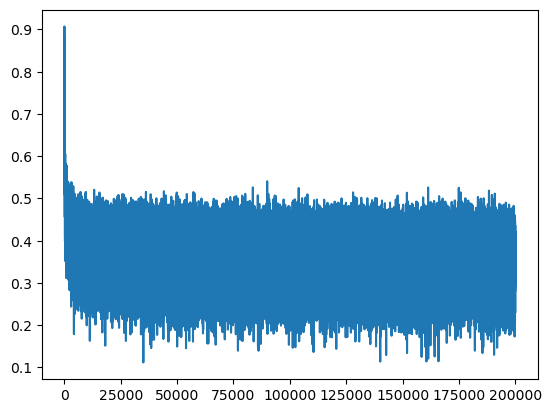

In [35]:
plt.plot(lossi)

In [44]:
# calculate the loss in the entire dataset
@torch.no_grad()
def split_test(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'text': (Xtest, Ytest)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_test('train')
split_test('val')

train 2.2745211124420166
val 2.5351569652557373


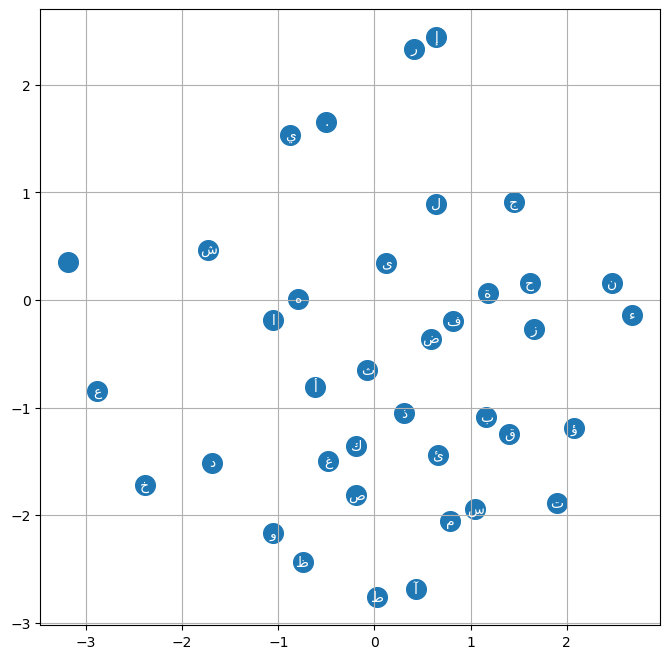

In [37]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

In [45]:
# ٍSampling from the model
for _ in range(10):
    block_size = 3
    context = [0] * block_size
    out = []

    while True:
        emb = C[context]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        out.append(ix)
        context = context[1:] + [ix]
        if ix == 0:
            break;

    print("".join(itoc[i] for i in out))

ينواي.
أنظمال.
قوولاء.
اروسة.
لاجب.
إحوق.
مبرخة.
هىامد.
حجطال.
خحاب.


In [42]:
context = [0] * block_size
C[context].shape

torch.Size([3, 10])